# Cookie Cats A/B Testing

Cookie Cats is a popular mobile game with more than 1M downloads and more than 77,000 reviews. The game is a "connect three" style puzzle game. As the players level up, they will find gates that force them to wait a time, watch an ad, or purchase to continue playing. In this project, we want to analyze the impact on player "retention" of moving the first gate from 30 to 40.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import io
import scipy.stats as stats
from scipy.stats import chi2
uploaded = files.upload()

Saving cookie_cats.csv to cookie_cats.csv


The data was collected by Tactile Entertainment, and it provides the following variables:

1.   userid - A unique number that identifies each player.
2.   version - Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
3.   sum_gamerounds - The number of game rounds played by the player during the first 14 days after install.
3.   retention_1 - Did the player come back and play 1 day after installing?
4.   retention_7 - Did the player come back and play 7 days after installing?

In [2]:
data = pd.read_csv(io.BytesIO(uploaded['cookie_cats.csv']))
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Exploratory Data Analysis

The data has 90189 values organized in 5 columns.

In [3]:
print(f'Table properties: {data.shape}')
print('_______________________________')
print(f'Values types: \n{data.dtypes}')
print('_______________________________')
print(f'General description of statistics: \n{data.describe()}')

Table properties: (90189, 5)
_______________________________
Values types: 
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
_______________________________
General description of statistics: 
             userid  sum_gamerounds
count  9.018900e+04    90189.000000
mean   4.998412e+06       51.872457
std    2.883286e+06      195.050858
min    1.160000e+02        0.000000
25%    2.512230e+06        5.000000
50%    4.995815e+06       16.000000
75%    7.496452e+06       51.000000
max    9.999861e+06    49854.000000


The goal of this project is to find a better way to increase retention. So far, the hypothesis is that moving the first gate from level 30 to level 40 will increase retention. However, **how much do they play?**

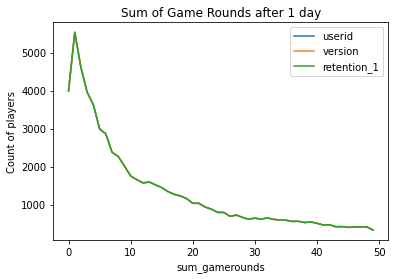

In [4]:
plot_df = data.groupby('sum_gamerounds').count()

ax = plot_df[:50].iloc[:, :3].plot()
ax.set_title("Sum of Game Rounds after 1 day")
ax.set_ylabel("Count of players")
plt.show()

The graph below shows that after 20 rounds, the number of users that continue engaged falls below 1000. The game rounds do not increase after seven days, either. 

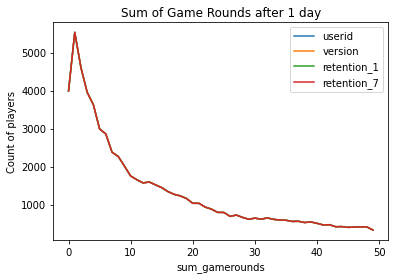

In [5]:
ax = plot_df[:50].plot()
ax.set_title("Sum of Game Rounds after 1 day")
ax.set_ylabel("Count of players")
plt.show()

Both graphs seem identical at first sight. It is clear that game rounds fall after 20 matches, so it is crucial to see whether changing the first gate will help to increase retention. 

In [6]:
gate_30 = data[data['version'] == 'gate_30']
gate_40 = data[data['version'] == 'gate_40']

bins = [0,1,10,20,30,40,50,60,70,80,90,100,200,500]
bins_gate_30 = pd.DataFrame(gate_30.groupby(pd.cut(gate_30["sum_gamerounds"], bins=bins)).count())
bins_gate_40 = pd.DataFrame(gate_40.groupby(pd.cut(gate_40["sum_gamerounds"], bins=bins)).count())

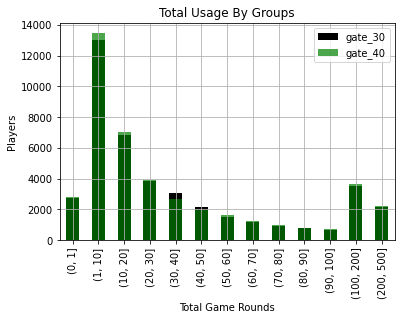

In [7]:
ax = bins_gate_30[:50].plot(kind = 'bar', y="userid", color = "black", 
                       title = 'Total Usage By Groups')
bins_gate_40[:50].plot(kind = 'bar', y="userid", ax=ax, color = "green", alpha = 0.7 )
ax.set_xlabel("Total Game Rounds")
ax.set_ylabel("Players")
plt.legend(["gate_30", "gate_40"])
plt.grid(True)

There is a slight difference in both groups, so it will be interesting to find how significant is the difference. There is an increase of game rounds when the first gate is at 30, but **how significant is the difference?**

In [8]:
gate_30_percent = round(data[data['version'] == 'gate_30']['retention_1'].mean(), 4)
gate_40_percent = round(data[data['version'] == 'gate_40']['retention_1'].mean(), 3)

print(f'Retention percentage at gate 30: {gate_30_percent * 100}%')
print(f'Retention percentage at gate 40: {gate_40_percent * 100}%')
print(f'Retention difference: {round(gate_30_percent - gate_40_percent, 4)*100}%')

Retention percentage at gate 30: 44.82%
Retention percentage at gate 40: 44.2%
Retention difference: 0.62%


Percent of retention is almost the same. However, there is a 0.62% difference, and that difference could mean an increase in earning from ads and conversion. By plotting the distributions of gate_30 and gate_40, it is clear that there is a big difference in their means. **However, how confident can we be that by moving the gate from 30 to 40 will bring a loss of 0.62%?**

In [9]:
distributions = []

for _ in range(1000):
  dist_mean = data.retention_1.sample(frac=1, replace=True).groupby(data.version).mean()
  distributions.append(dist_mean)

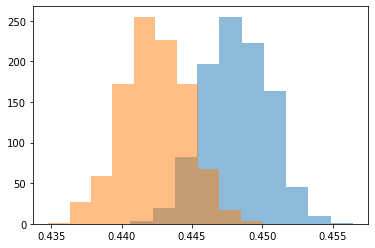

In [10]:
distributions = pd.DataFrame(distributions)
plt.hist(distributions['gate_30'], alpha = 0.5)
plt.hist(distributions['gate_40'], alpha = 0.5)
plt.show()

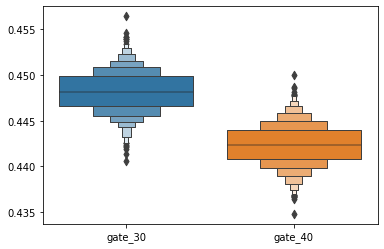

In [11]:
g = sns.boxenplot(data=[distributions['gate_30'],
                        distributions['gate_40']])
                        
g.set(xticklabels = ['gate_30', 'gate_40'])
plt.show()

The data is close to half for gate_30 and half for gate_40. However, the information we need to test the hypothesis is categorical. Therefore, a Chi-Square will be the tool used for the analysis.

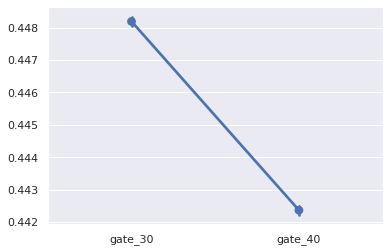

In [35]:
g = sns.pointplot(data=[distributions['gate_30'],
                        distributions['gate_40']])
                        
g.set(xticklabels = ['gate_30', 'gate_40'])
plt.show()

In [12]:
pd.crosstab(data['version'], data['retention_1'], margins = True)

retention_1,False,True,All
version,,,
gate_30,24666,20034,44700
gate_40,25370,20119,45489
All,50036,40153,90189


In [13]:
# Getting the observations and expected
observed_values = pd.crosstab(data['version'], data['retention_1'])
contingency = stats.chi2_contingency(observed_values)
expected_values = contingency[3]

print(f'Observed values: \n{observed_values.values}\n')
print(f'Expected values: \n{expected_values}')

Observed values: 
[[24666 20034]
 [25370 20119]]

Expected values: 
[[24799.13514952 19900.86485048]
 [25236.86485048 20252.13514952]]


In [14]:
# Finding degree of freedom
num_rows = len(observed_values)
num_cols = len(observed_values)
dof = (num_rows - 1) * (num_cols - 1)
alpha = 0.05

print(f'Degree of freedom: {dof}')

Degree of freedom: 1


Now that we have set the alpha, and we have found the degree of freedom, observed, and expected values, it is time to compute the **Chi-Square**

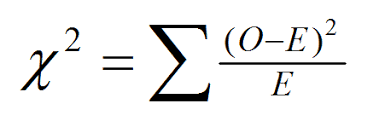

In [15]:
def chi2_stats(observed, expected):
  chi_square = sum([(o - e)**2./e for o,e in zip(observed, expected)])
  chi_square_statistics = chi_square[0] + chi_square[1]

  print(f'Chi-Square Statistics: {chi_square_statistics}')
  return chi_square_statistics

In [16]:
chi2_statistics = chi2_stats(observed_values.values, expected_values)

Chi-Square Statistics: 3.182963657512031


In [17]:
critical_value = chi2.ppf(q=1-alpha, df = dof)
critical_value

3.841458820694124

In [18]:
# Finding the P-Value
p_value = 1 - chi2.cdf(x=chi2_statistics, df=dof)
print(f'p-value: {p_value}')
print(f'significance level: {alpha}')
print(f'degree of freedom: {dof}')

p-value: 0.0744096552969219
significance level: 0.05
degree of freedom: 1


In [19]:
if chi2_statistics >= critical_value:
  print("Reject H0, there is a relationship between two categorical variables")
else:
  print("Retain H0, there is no a relationship between two categorical variables")

if p_value <= alpha:
  print("Reject H0, there is a relationship between two categorical variables")
else:
  print("Retain H0, there is no a relationship between two categorical variables")

Retain H0, there is no a relationship between two categorical variables
Retain H0, there is no a relationship between two categorical variables


According to the result obtained from the Chi-square, the gates are not related to retention. However, we have seen more rounds of games at gate 30 than at level 40. 

The probability of retention at each level might help to clarify the situation.

In [20]:
# Finding the difference in the retention distribution
distributions["difference"] = distributions.gate_30 - distributions.gate_40

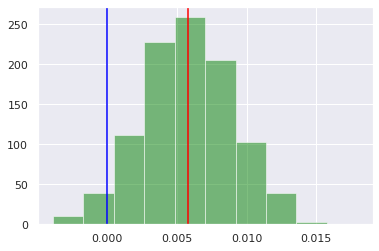

In [36]:
plt.hist(distributions['difference'], alpha = 0.5, color= 'green')
plt.axvline(x=distributions['difference'].mean(), color='red')
plt.axvline(x=0.0, color='blue')
plt.show()

Most of the distribution under the curve is positive. Therefore, the retention percent is higher at gate 30. However, **what is the probability that the retention will be higher after one day of installing the game?**

In [22]:
# Finding the probability that retention at gate 30 will be higher
prob = (distributions['difference']>0).sum()/len(distributions)

print(f'Probability of that the retention will be higher at gate 30 after 1 day since downloading the game: {prob*100}%')

Probability of that the retention will be higher at gate 30 after 1 day since downloading the game: 96.8%


# Analyzing retention after 7 days

After 1 day since installing the game, retention is higher at gate 30. We want to know if the condition is the same after 7 days. 

In [23]:
gate_30_percent = round(data[data['version'] == 'gate_30']['retention_7'].mean(), 4)
gate_40_percent = round(data[data['version'] == 'gate_40']['retention_7'].mean(), 3)

print(f'Retention percentage at gate 30: {gate_30_percent * 100}%')
print(f'Retention percentage at gate 40: {gate_40_percent * 100}%')
print(f'Retention difference: {round(gate_30_percent - gate_40_percent, 3)*100}%')

Retention percentage at gate 30: 19.02%
Retention percentage at gate 40: 18.2%
Retention difference: 0.8%


After 7 days, retention has fallen even more, but the difference is two point higher.

In [24]:
t1 = pd.crosstab(data['version'], data['retention_7'], margins = True)
t1

retention_7,False,True,All
version,,,
gate_30,36198,8502,44700
gate_40,37210,8279,45489
All,73408,16781,90189


In [25]:
# Getting the observations and expected
observed_values = pd.crosstab(data['version'], data['retention_7'])
contingency = stats.chi2_contingency(observed_values)
expected_values = contingency[3]

print(f'Observed values: \n{observed_values.values}\n')
print(f'Expected values: \n{expected_values}')

Observed values: 
[[36198  8502]
 [37210  8279]]

Expected values: 
[[36382.90257127  8317.09742873]
 [37025.09742873  8463.90257127]]


In [26]:
# Finding degree of freedom
num_rows = len(observed_values)
num_cols = len(observed_values)
dof = (num_rows - 1) * (num_cols - 1)
alpha = 0.05

print(f'Degree of freedom: {dof}')

Degree of freedom: 1


In [27]:
chi2_statistics = chi2_stats(observed_values.values, expected_values)

Chi-Square Statistics: 10.013167328688969


In [28]:
critical_value = chi2.ppf(q=1-alpha, df = dof)
critical_value

3.841458820694124

In [29]:
# Finding the P-Value
p_value = 1 - chi2.cdf(x=chi2_statistics, df=dof)
print(f'p-value: {p_value}')
print(f'significance level: {alpha}')
print(f'degree of freedom: {dof}')

p-value: 0.0015542499756142636
significance level: 0.05
degree of freedom: 1


In [30]:
if chi2_statistics >= critical_value:
  print("Reject H0, there is a relationship between two categorical variables")
else:
  print("Retain H0, there is no a relationship between two categorical variables")

if p_value <= alpha:
  print("Reject H0, there is a relationship between two categorical variables")
else:
  print("Retain H0, there is no a relationship between two categorical variables")

Reject H0, there is a relationship between two categorical variables
Reject H0, there is a relationship between two categorical variables


There is a relationship between retention and the version of the game after 7 days. Therefore, with a higher retention percent, we have enough evidence to keep the gate at level 30

To see how strong the relationship is between version and retention after 7 days. I will conduct an effect size test. 

In [31]:
from statsmodels.stats.power import TTestIndPower

analysis = TTestIndPower()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [32]:
result = analysis.solve_power(effect_size=None, power=0.8, nobs1=t1.iloc[2,2], ratio=1.0, alpha=0.05)
print('The effect size needed for this experiment would be {}'.format(result))

The effect size needed for this experiment would be 0.013192984981012151


It was expected that moving the first gate from 30 to level 40 will increase retention. However, the analysis shows that it is not the case. Graphs showed that people started to lose interest in the game after 20 rounds. People who reach level 30, and are forced to stop, have a more significant motivation to come back later or make a purchase to continue playing. However, by the time a user reaches level 40, interest might have decrease.